<h1 style="text-align:center">Satellite Image Classification<a class="anchor" id = "2"></a></h1>

<h2 style="text-align:center">Data PreProcessing<a class="anchor" id = "2"></a></h2>

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools, math
import os 
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, AveragePooling2D, Flatten, Concatenate)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, Callback

### Train, validation, and test datasets

In [2]:
IMG_SIZE = 64
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_csv = pd.read_csv('E:/final year project/EuroSAT/satellite image classification/Train/EuroSAT/train.csv')
validation_csv = pd.read_csv('E:/final year project/EuroSAT/satellite image classification/Train/EuroSAT/validation.csv')
test_csv = pd.read_csv('E:/final year project/EuroSAT/satellite image classification/Train/EuroSAT/test.csv')

def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0  
    return image

def augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    return image

def create_dataset_from_dataframe(df, base_dir, num_classes, augment_data=False):
    if 'Filename' not in df.columns or 'Label' not in df.columns:
        raise KeyError("DataFrame must contain 'Filename' and 'Label' columns")

    image_paths = df['Filename'].apply(lambda x: os.path.join(base_dir, x)).tolist()
    labels = df['Label'].tolist()
    
    labels = tf.keras.utils.to_categorical(labels, num_classes)
    
    # Verify paths
    for path in image_paths:
        if not os.path.isfile(path):
            print(f"File does not exist: {path}")

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=AUTOTUNE)
    if augment_data:
        ds = ds.map(lambda x, y: (augment(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = create_dataset_from_dataframe(train_csv, 'E:/final year project/EuroSAT/satellite image classification/Train/EuroSAT', num_classes=10, augment_data=True)
validation_ds = create_dataset_from_dataframe(validation_csv, 'E:/final year project/EuroSAT/satellite image classification/Validation/EuroSAT', num_classes=10)
test_ds = create_dataset_from_dataframe(test_csv, 'E:/final year project/EuroSAT/satellite image classification/Test/EuroSAT', num_classes=10)



In [3]:
print("Train CSV columns:", train_csv.columns)
print("Validation CSV columns:", validation_csv.columns)
print("Test CSV columns:", test_csv.columns)


Train CSV columns: Index(['Unnamed: 0', 'Filename', 'Label', 'ClassName'], dtype='object')
Validation CSV columns: Index(['Unnamed: 0', 'Filename', 'Label', 'ClassName'], dtype='object')
Test CSV columns: Index(['Unnamed: 0', 'Filename', 'Label', 'ClassName'], dtype='object')


In [4]:
print("Train CSV head:\n", train_csv.head())
print("Validation CSV head:\n", validation_csv.head())
print("Test CSV head:\n", test_csv.head())

Train CSV head:
    Unnamed: 0                                           Filename  Label  \
0       16257                      AnnualCrop/AnnualCrop_142.jpg      0   
1        3297  HerbaceousVegetation/HerbaceousVegetation_2835...      2   
2       17881               PermanentCrop/PermanentCrop_1073.jpg      6   
3        2223                      Industrial/Industrial_453.jpg      4   
4        4887  HerbaceousVegetation/HerbaceousVegetation_1810...      2   

              ClassName  
0            AnnualCrop  
1  HerbaceousVegetation  
2         PermanentCrop  
3            Industrial  
4  HerbaceousVegetation  
Validation CSV head:
    Unnamed: 0                  Filename  Label ClassName
0         258  Pasture/Pasture_1481.jpg      5   Pasture
1        2134    Forest/Forest_2638.jpg      1    Forest
2        3518   Highway/Highway_875.jpg      3   Highway
3        3048       River/River_434.jpg      8     River
4        3996  SeaLake/SeaLake_2930.jpg      9   SeaLake
Test CSV hea

### Data sample visualization

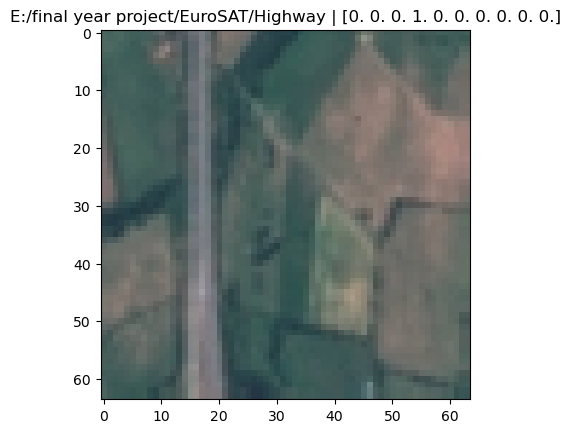

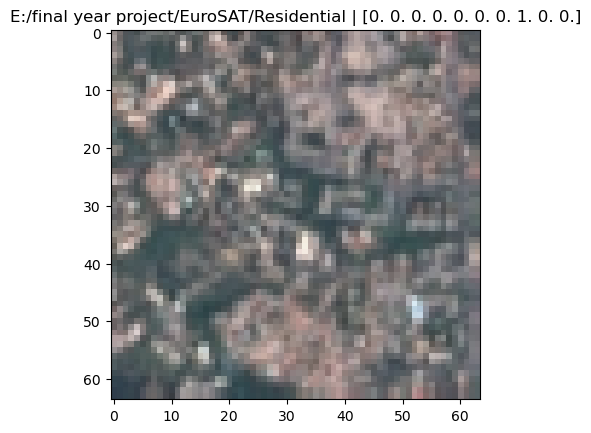

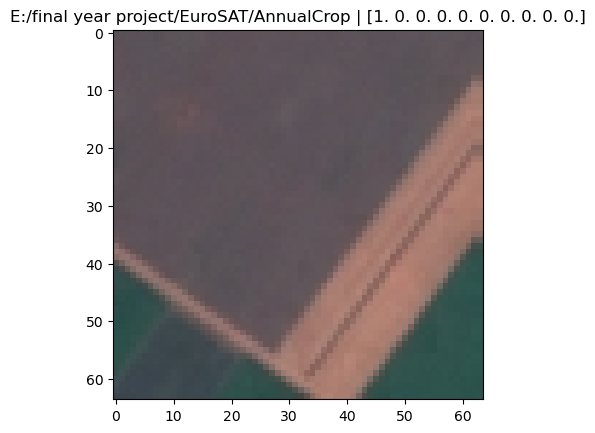

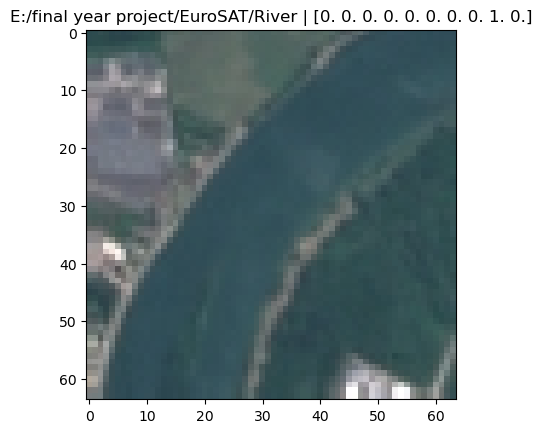

In [5]:
data_sample = train_ds.as_numpy_iterator()
res = data_sample.next()
classNamesLabels = {
    0: 'E:/final year project/EuroSAT/AnnualCrop',
    1: 'E:/final year project/EuroSAT/Forest',
    2: 'E:/final year project/EuroSAT/HerbaceousVegetation',
    3: 'E:/final year project/EuroSAT/Highway',
    4: 'E:/final year project/EuroSAT/Industrial',
    5: 'E:/final year project/EuroSAT/Pasture',
    6: 'E:/final year project/EuroSAT/PermanentCrop',
    7: 'E:/final year project/EuroSAT/Residential',
    8: 'E:/final year project/EuroSAT/River',
    9: 'E:/final year project/EuroSAT/SeaLake'
}
for idx in range(4):
    Image = np.clip(res[0][idx], 0, 1) 
    Label = res[1][idx]
    plt.figure()
    plt.imshow(Image)
    plt.title(f"{classNamesLabels[np.argmax(Label)]} | {Label}")
    plt.show()



<h2 style="text-align:center">Model building <a class="anchor" id = "3"></a></h2>
<p style="text-align:center">Convolutional Neural Network (CNN).</p>

In [6]:
 def spectral_block(X, filters, stage, s=1):
    squeeze_base_name = 'squeeze_' + str(stage) + '_branch'
    bn_base_name = 'bn_' + str(stage) + "_branch"
    
    F1, F2, F3 = filters
    
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='same', name=squeeze_base_name + 'a')(X)
    
    X_11 = Conv2D(filters=F2, kernel_size=(1, 1), strides=(s, s), padding='same', name=squeeze_base_name + 'b')(X)
    X_33 = Conv2D(filters=F3, kernel_size=(3, 3), strides=(s, s), padding='same', name=squeeze_base_name + 'c')(X)
    
    X = Concatenate(name="concatenate_" + str(stage))([X_11, X_33])
    X = BatchNormalization(name=bn_base_name)(X)
    X = Activation("relu", name="spectral" + str(stage))(X)
    
    return X

def SpectrumNet(input_shape, classes):
    X_input = Input(input_shape, name="input")
    
    X = Conv2D(96, (1, 1), strides=(2, 2), name='conv1', padding="same")(X_input)
    
    X = spectral_block(X, [16, 96, 32], 2)
    X = spectral_block(X, [16, 96, 32], 3)
    X = spectral_block(X, [32, 192, 64], 4)
    
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same", name="maxpool4")(X)
    
    X = spectral_block(X, [32, 192, 64], 5)
    X = spectral_block(X, [48, 288, 96], 6)
    X = spectral_block(X, [48, 288, 96], 7)
    X = spectral_block(X, [64, 384, 128], 8)
    
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same", name="maxpool8")(X)
    
    X = spectral_block(X, [64, 384, 128], 9)
    
    X = Conv2D(classes, kernel_size=(1, 1), strides=(1, 1), name="conv10", padding='same')(X)
    X = BatchNormalization(name="conv10_batchnormalisation")(X)
    X = Activation("relu", name="conv10_activation")(X)
    
    X = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), name="avgpool10")(X)
    
    X = Flatten(name="flatten10")(X)
    X = Activation("softmax", name="output")(X)
    
    model = Model(inputs=X_input, outputs=X, name="SpectrumNet")
    
    return model

In [7]:
model = SpectrumNet(input_shape=(IMG_SIZE, IMG_SIZE, 3), classes=10)
model.summary()



Model: "SpectrumNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 96)           384       ['input[0][0]']               
                                                                                                  
 squeeze_2_brancha (Conv2D)  (None, 32, 32, 16)           1552      ['conv1[0][0]']               
                                                                                                  
 squeeze_2_branchb (Conv2D)  (None, 32, 32, 96)           1632      ['squeeze_2_brancha[0][0]']   
                                                                                      

<h2 style="text-align:center">Model training <a class="anchor" id = "4"></a></h2>

### Auxiliary functions

In [8]:
def compute_class_weights(labels, num_classes):
    class_totals = np.bincount(labels, minlength=num_classes)
    class_weights = {i: class_totals.max() / class_totals[i] for i in range(num_classes)}
    return class_weights

def show_final_history(history):
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].plot(history.history['loss'], 'r-', label='Training Loss')
    ax[0].plot(history.history['val_loss'], 'g-', label='Validation Loss')
    ax[1].plot(history.history['categorical_accuracy'], 'r-', label='Training Accuracy')
    ax[1].plot(history.history['val_categorical_accuracy'], 'g-', label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    
    plt.show()

def plot_learning_rate(loss_history):
    plt.style.use("ggplot")
    plt.plot(np.arange(0, len(loss_history.lr)), loss_history.lr)
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max() / 2.0
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(False)
    plt.show()

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

## Training

Epoch 1/50


591/591 [==============================] - ETA: 0s - loss: 1.6401 - categorical_accuracy: 0.5867
Epoch 1: val_categorical_accuracy improved from -inf to 0.14833, saving model to satelliteImageClassifierWeights.keras
591/591 [==============================] - 438s 675ms/step - loss: 1.6401 - categorical_accuracy: 0.5867 - val_loss: 3.5136 - val_categorical_accuracy: 0.1483 - lr: 0.0010
Epoch 2/50
591/591 [==============================] - ETA: 0s - loss: 1.2310 - categorical_accuracy: 0.6966
Epoch 2: val_categorical_accuracy improved from 0.14833 to 0.15074, saving model to satelliteImageClassifierWeights.keras
591/591 [==============================] - 363s 595ms/step - loss: 1.2310 - categorical_accuracy: 0.6966 - val_loss: 2.7812 - val_categorical_accuracy: 0.1507 - lr: 0.0010
Epoch 3/50
591/591 [==============================] - ETA: 0s - loss: 1.0373 - categorical_accuracy: 0.7331
Epoch 3: val_categorical_accuracy did not improve from 0.15074
591/591 [=================

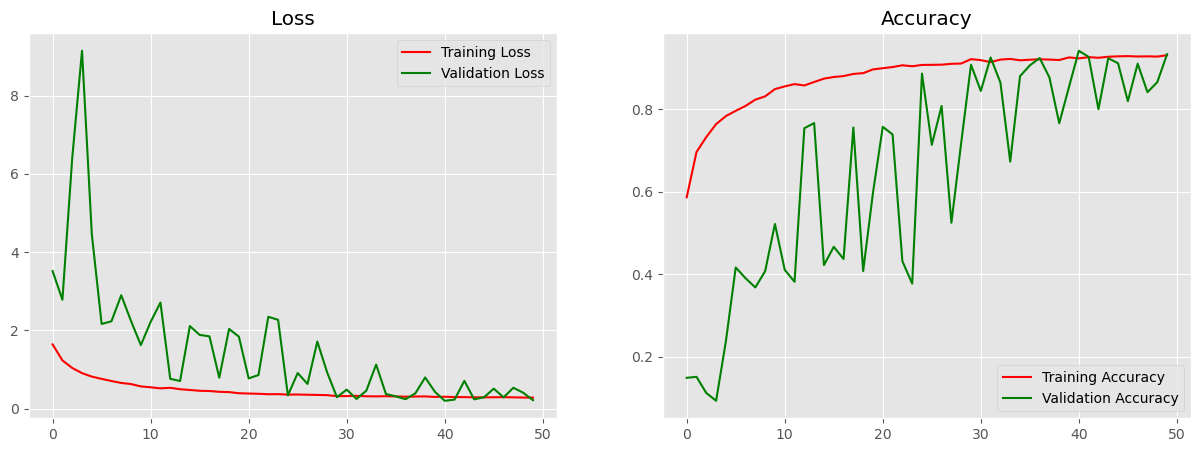

In [9]:
train_labels = train_csv['Label'].to_numpy()
class_weights = compute_class_weights(train_labels, num_classes=10)

checkpoint = ModelCheckpoint("satelliteImageClassifierWeights.keras", monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
logs = TensorBoard(log_dir="logs", histogram_freq=1)

loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)

opt = SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

epochs = 50
batchSize = 32
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=validation_ds,
                    callbacks=[checkpoint, lrate, loss_history],
                    class_weight=class_weights)

show_final_history(history)

## Saving the model

In [10]:
model.save('Satellite_Image_Classifier_Model.keras')
print("Model saved successfully.")
model.save_weights('.weights.h5')
print("Model weights saved successfully.")

Model saved successfully.
Model weights saved successfully.


<h2 style="text-align:center">Model evaluation <a class="anchor" id = "5"></a></h2>
<p style="text-align:center">The model will be evaluated using the test dataset.</p>

85/85 [==============================] - 22s 184ms/step - loss: 0.1928 - categorical_accuracy: 0.9470
Test loss: 0.19280406832695007
Test accuracy: 0.9470370411872864
85/85 [==============================] - 17s 181ms/step


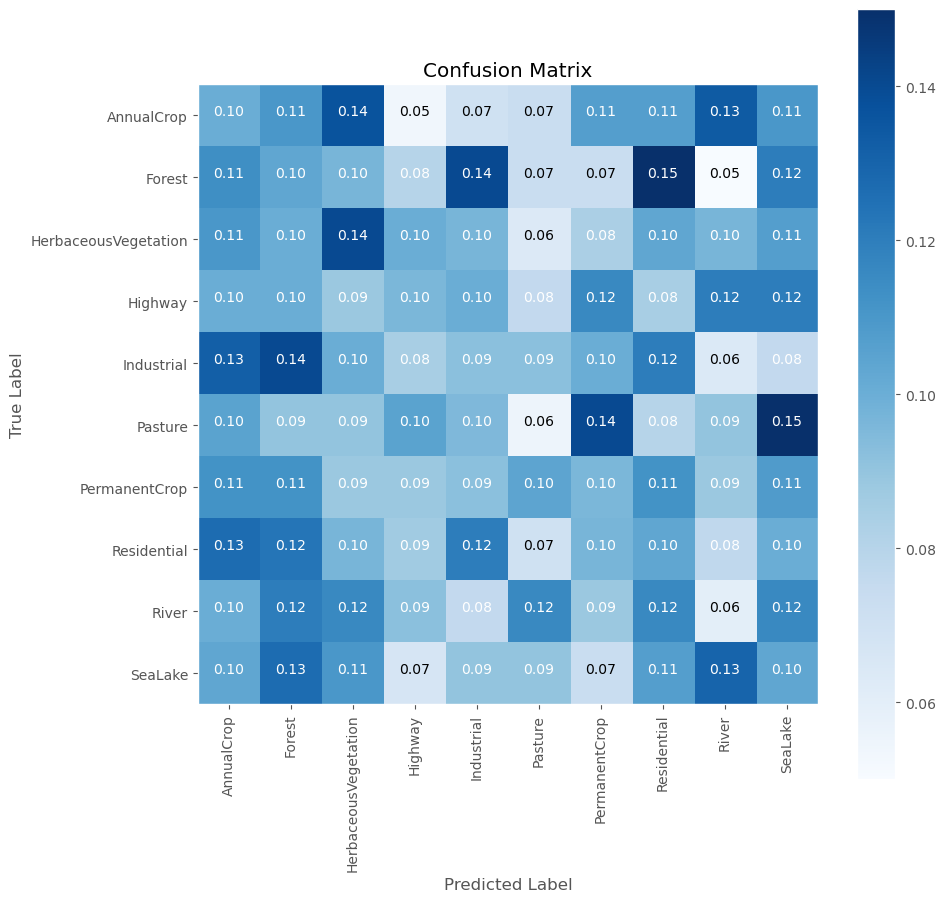

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

test_predictions = model.predict(test_ds)
test_pred_labels = np.argmax(test_predictions, axis=1)

test_true_labels = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

test_true_labels = np.argmax(test_true_labels, axis=1)

cm = confusion_matrix(test_true_labels, test_pred_labels)

class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

<h2 style="text-align:center">Optimizing model performance <a class="anchor" id = "6"></a></h2>

<p>To optimize the model performance, three versions of training were conducted with variations in the step_decay parameters. Each version aimed to identify the best learning rate schedule for optimal model accuracy and generalization.</p>

<table style="width:100%; border: 1px solid black; border-collapse: collapse; text-align: center;">
  <thead style="border: 1px solid black; padding: 8px;">
    <tr>
      <th style="border: 1px solid black; padding: 8px;">Version</th>
      <th style="border: 1px solid black; padding: 8px;">Initial Learning Rate</th>
      <th style="border: 1px solid black; padding: 8px;">Drop</th>
      <th style="border: 1px solid black; padding: 8px;">Epochs Drop</th>
      <th style="border: 1px solid black; padding: 8px;">Optimizer</th>
      <th style="border: 1px solid black; padding: 8px;">Best Model (Epochs)</th>
      <th style="border: 1px solid black; padding: 8px;">Training Accuracy</th>
      <th style="border: 1px solid black; padding: 8px;">Test Loss</th>
      <th style="border: 1px solid black; padding: 8px;">Test Accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">Version 1</td>
      <td style="border: 1px solid black; padding: 8px;">0.0005</td>
      <td style="border: 1px solid black; padding: 8px;">0.5</td>
      <td style="border: 1px solid black; padding: 8px;">20.0</td>
      <td style="border: 1px solid black; padding: 8px;">SGD (1e-4, 0.9, True)</td>
      <td style="border: 1px solid black; padding: 8px;">70</td>
      <td style="border: 1px solid black; padding: 8px;">95.41%</td>
      <td style="border: 1px solid black; padding: 8px;">0.1449</td>
      <td style="border: 1px solid black; padding: 8px;">95.74%</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">Version 2</td>
      <td style="border: 1px solid black; padding: 8px;">0.001</td>
      <td style="border: 1px solid black; padding: 8px;">0.5</td>
      <td style="border: 1px solid black; padding: 8px;">10.0</td>
      <td style="border: 1px solid black; padding: 8px;">SGD (1e-4, 0.9, True)</td>
      <td style="border: 1px solid black; padding: 8px;">50</td>
      <td style="border: 1px solid black; padding: 8px;">97.09%</td>
      <td style="border: 1px solid black; padding: 8px;">0.1364</td>
      <td style="border: 1px solid black; padding: 8px;">96.33%</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">Version 3</td>
      <td style="border: 1px solid black; padding: 8px;">0.001</td>
      <td style="border: 1px solid black; padding: 8px;">0.1</td>
      <td style="border: 1px solid black; padding: 8px;">30.0</td>
      <td style="border: 1px solid black; padding: 8px;">SGD (1e-4, 0.9, True)</td>
      <td style="border: 1px solid black; padding: 8px;">50</td>
      <td style="border: 1px solid black; padding: 8px;">97.06%</td>
      <td style="border: 1px solid black; padding: 8px;">0.1062</td>
      <td style="border: 1px solid black; padding: 8px;">96.93%</td>
    </tr>
  </tbody>
</table>

<h3 style="text-align:center">Confusion matrix analysis</h3>

<p>The confusion matrices for the best models of each version show the detailed performance across the 10 classes. The matrices provide insights into the specific classes that the models struggled to classify correctly, allowing for targeted improvements.</p>

<div style='justify-content: center; display: flex;'>
  <div>
    <img src="https://raw.githubusercontent.com/AlvaroVasquezAI/Satellite_Image_Classification/4ba3f60285f9367170a17e86342f4952fba263ad//Models/Version1/ConfusionMatrices/confusionMatrix70Epochs.png" width='100%'/>
    <p style='text-align: center'>Confusion matrix version 1</p>
  </div>
  <div>
    <img src="https://raw.githubusercontent.com/AlvaroVasquezAI/Satellite_Image_Classification/4ba3f60285f9367170a17e86342f4952fba263ad//Models/Version2/ConfusionMatrices/confusionMatrix50Epochs.png" width='100%'/>
    <p style='text-align: center'>Confusion matrix version 2</p>
  </div>
  <div>
    <img src="https://raw.githubusercontent.com/AlvaroVasquezAI/Satellite_Image_Classification/4ba3f60285f9367170a17e86342f4952fba263ad//Models/Version3/ConfusionMatrices/confusionMatrix50Epochs.png" width='100%'/>
    <p style='text-align: center'>Confusion matrix version 3</p>
  </div>
</div>

<h3 style="text-align:center">Loss and accuracy curves</h3>

<p>The training and validation loss and accuracy curves for the best models in each version show how the model's performance evolved over epochs. The curves help identify overfitting, underfitting, and the stability of the learning process.</p>

<div style='justify-content: center; display: flex;'>
  <div>
    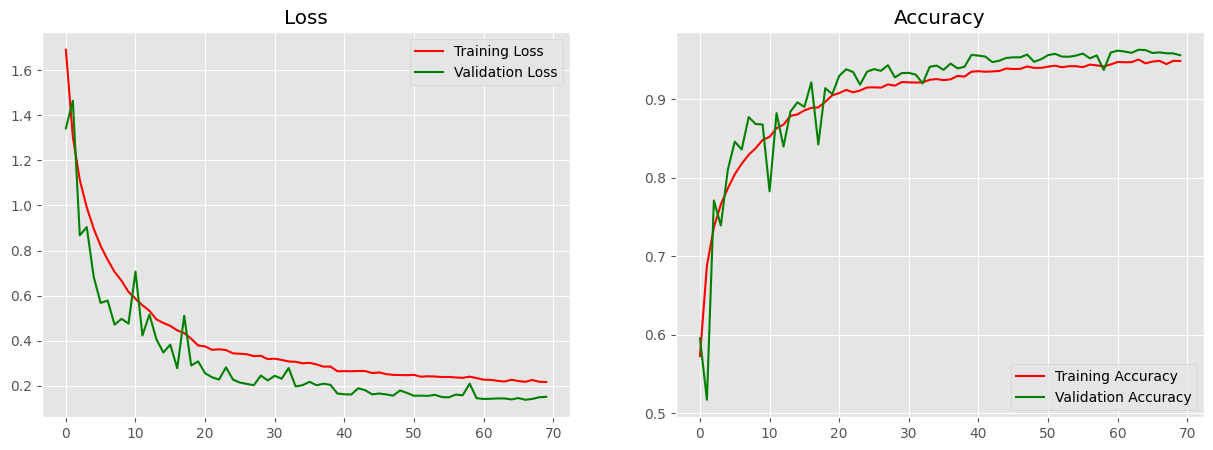
    <p style='text-align: center'>Loss and accuracy curves version 1</p>
  </div>
  <div>
    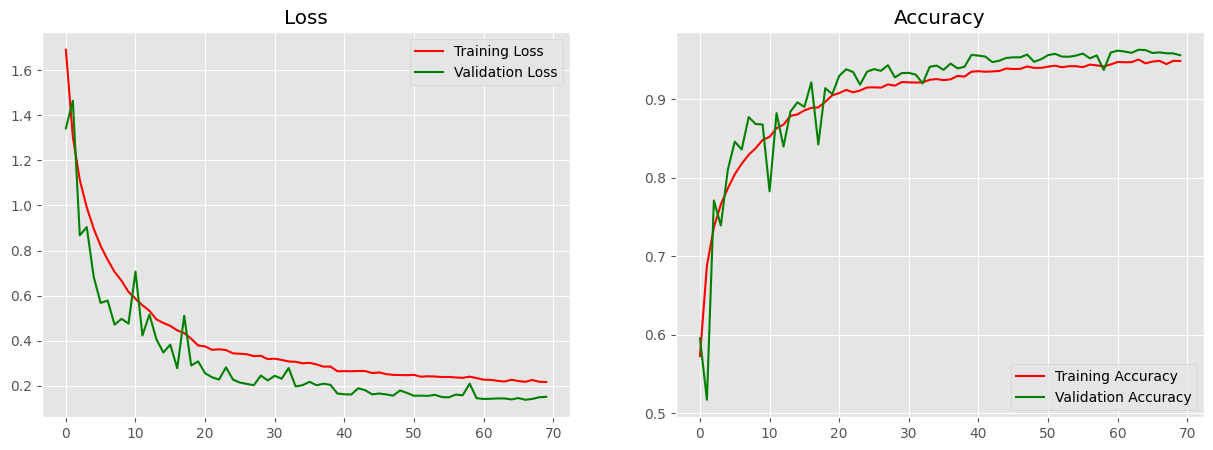
    <p style='text-align: center'>Loss and accuracy curves version 2</p>
  </div>
  <div>
    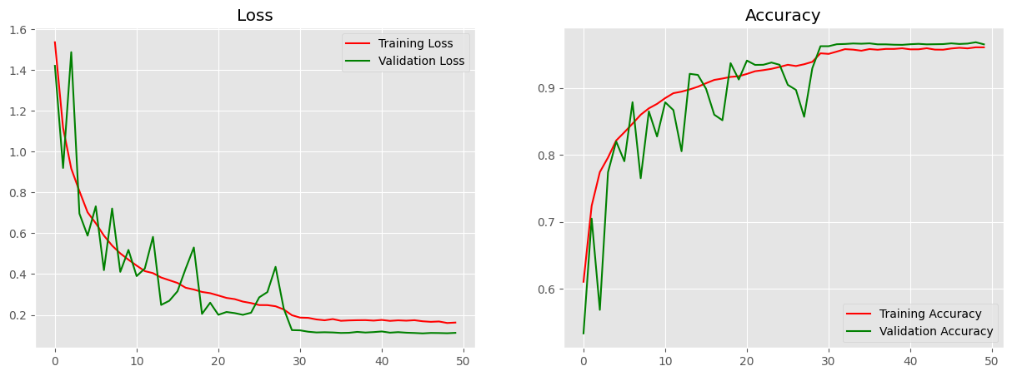
    <p style='text-align: center'>Loss and accuracy curves version 3</p>
  </div>
</div>

<h2 style="text-align:center">Predictions <a class="anchor" id = "7"></a></h2>

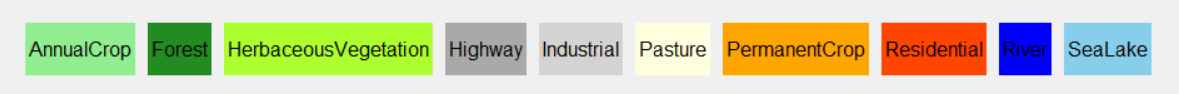

In [1]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

class SatelliteImageClassification:
    def __init__(self):
        self.model = None
        self.path = None

    def load_model_SIC(self, model_path):
        self.path = model_path
        self.model = load_model(model_path)

    def load_image(self, image_path):
        image = load_img(image_path, target_size=(256, 256))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image /= 255.0
        return image

    def process_image(self, image_path):
        grid_size = 64
        class_colors = {
            0: [144, 238, 144],  # Light Green for AnnualCrop
            1: [34, 139, 34],    # Dark Green for Forest
            2: [173, 255, 47],   # Yellow-Green for HerbaceousVegetation
            3: [169, 169, 169],  # Gray for Highway
            4: [211, 211, 211],  # Light Gray for Industrial
            5: [255, 255, 224],  # Light Yellow for Pasture
            6: [255, 165, 0],    # Light Orange for PermanentCrop
            7: [255, 69, 0],     # Dark Orange for Residential
            8: [0, 0, 255],      # Blue for River
            9: [135, 206, 235]   # Light Blue for SeaLake
        }
        class_names = [
            'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
            'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'
        ]

        # Load and preprocess the real image
        real_image = load_img(image_path)
        real_image = img_to_array(real_image)
        real_image = real_image / 255.0  # Normalize pixel values

        # Divide the resized image into grids
        grids = self.divide_image_into_grids(real_image, grid_size)

        # Predict the class of each grid
        predictions = self.model.predict(grids)
        predicted_classes = np.argmax(predictions, axis=1)

        # Colorize the grids according to the predicted classes
        colored_image = self.colorize_grids(real_image, predicted_classes, grid_size, class_colors, real_image.shape[0], real_image.shape[1])

        return real_image, colored_image

    def divide_image_into_grids(self, image, grid_size):
        img_height, img_width, _ = image.shape
        grids = []
        for y in range(0, img_height, grid_size):
            for x in range(0, img_width, grid_size):
                grid = image[y:y+grid_size, x:x+grid_size]
                if grid.shape[0] != grid_size or grid.shape[1] != grid_size:
                    grid = cv2.resize(grid, (grid_size, grid_size))
                grids.append(grid)
        return np.array(grids)

    def colorize_grids(self, original_image, predictions, grid_size, class_colors, img_height, img_width):
        colored_image = np.zeros_like(original_image)
        grid_idx = 0
        for y in range(0, img_height, grid_size):
            for x in range(0, img_width, grid_size):
                if grid_idx < len(predictions):
                    color = np.array(class_colors[predictions[grid_idx]]) / 255.0
                    actual_grid_height = min(grid_size, img_height - y)
                    actual_grid_width = min(grid_size, img_width - x)
                    resized_color = cv2.resize(np.full((grid_size, grid_size, 3), color), (actual_grid_width, actual_grid_height))
                    colored_image[y:y+actual_grid_height, x:x+actual_grid_width] = resized_color
                    # Draw grid lines
                    cv2.rectangle(colored_image, (x, y), (x + actual_grid_width, y + actual_grid_height), (0, 0, 0), 1)
                    # Put grid numbers
                    cv2.putText(colored_image, str(grid_idx), (x + 5, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                    grid_idx += 1
        return colored_image
    
    def plot_images(self, original_image, colored_image):
        import matplotlib.pyplot as plt
        
        original_image = (original_image * 255).astype(np.uint8)
        colored_image = (colored_image * 255).astype(np.uint8)
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 15))
        axs[0].imshow(original_image)
        axs[0].set_title('Image')
        axs[0].axis('off')
        axs[1].imshow(colored_image)
        axs[1].set_title('Predictions')
        axs[1].axis('off')

        model_name = self.path.split('/')[-1]
        
        plt.suptitle(model_name, fontsize=12)
        plt.subplots_adjust(top=1.57)
        plt.show()


In [5]:
import os

image_path = 'E:/final year project/EuroSAT/satellite image classification/Satellite Images/5.jpg'
model_paths = [
    'E:/final year project/EuroSAT/satellite image classification/Model/Model_V1_70.keras',
    'E:/final year project/EuroSAT/satellite image classification/Model/Model_V2_50.keras',
    'E:/final year project/EuroSAT/satellite image classification/Model/Model_V3_50.keras'
]

if not os.path.isfile(image_path):
    print("Image file does not exist.")
for path in model_paths:
    if not os.path.isfile(path):
        print(f"Model file does not exist: {path}")


In [7]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [10]:
def load_model_SIC(self, model_path):
    from tensorflow.keras.saving import saving_api

    try:
        self.path = model_path
        # Ensure you're using the right version of the Keras/TensorFlow API
        self.model = saving_api.load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
    except ModuleNotFoundError as e:
        print(f"ModuleNotFoundError: {e}")
        print("Ensure that your TensorFlow and Keras versions are compatible with the model format.")
    except TypeError as e:
        print(f"TypeError: {e}")
        print("There might be an issue with the model file format or TensorFlow/Keras versions.")
    except Exception as e:
        print(f"An error occurred: {e}")



In [11]:
from tensorflow.keras.models import load_model

def load_model_SIC(self, model_path):
    try:
        self.path = model_path
        self.model = load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
    except Exception as e:
        print(f"An error occurred: {e}")




Model V1_70 loaded.
64/64 [==============================] - 13s 183ms/step
Image processed.


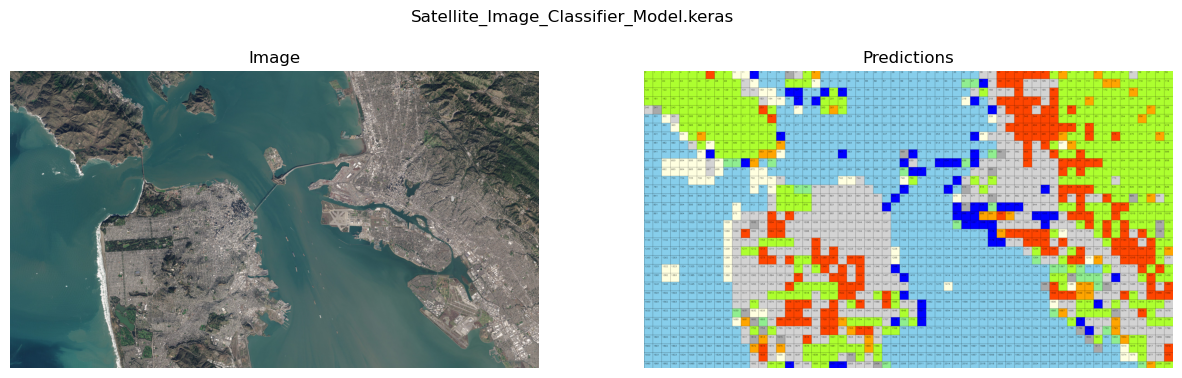

In [12]:
classifierV150I5 = SatelliteImageClassification()
classifierV150I5.load_model_SIC('C:/Users/Sowmya Gottumukkala/Satellite_Image_Classifier_Model.keras')
print("Model V1_70 loaded.")
original_image, colored_image = classifierV150I5.process_image(image)
print("Image processed.")
classifierV150I5.plot_images(original_image, colored_image)


64/64 [==============================] - 13s 191ms/step


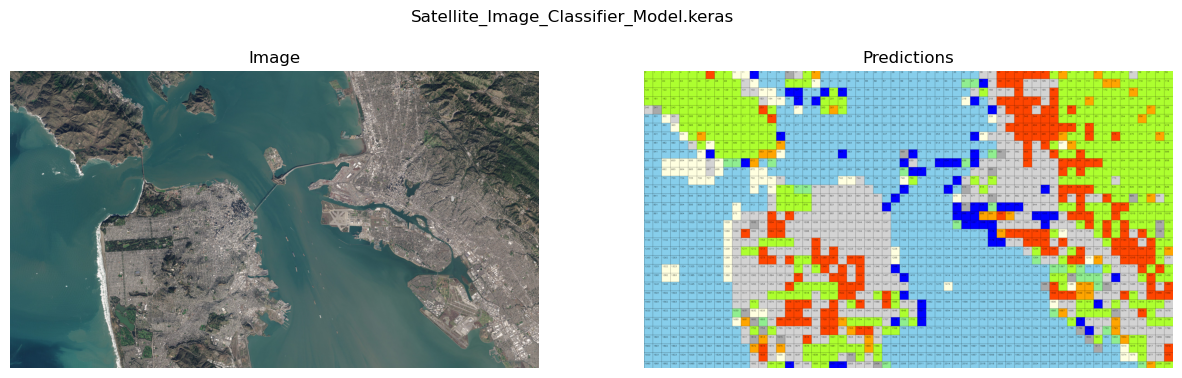

64/64 [==============================] - 12s 186ms/step


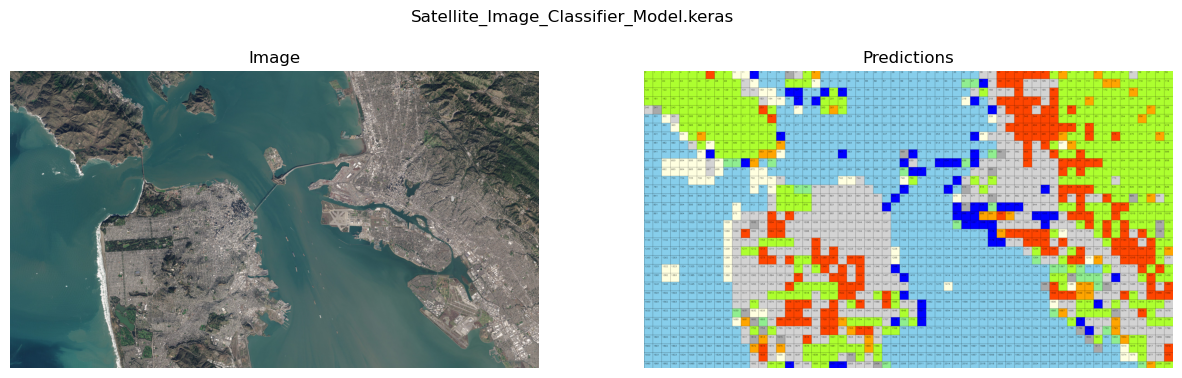

64/64 [==============================] - 12s 188ms/step


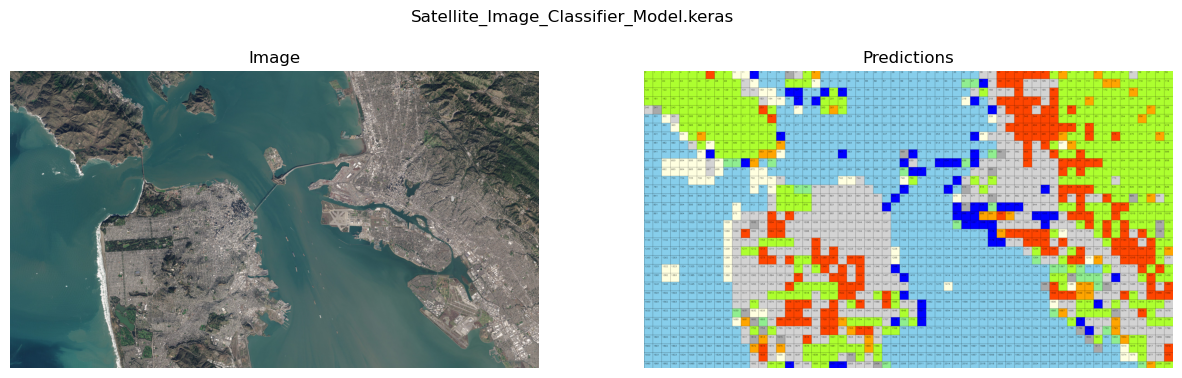

In [13]:
from classifier import SatelliteImageClassification

image = 'E:/final year project/EuroSAT/satellite image classification/Satellite Images/5.jpg'

classifierV150I5 = SatelliteImageClassification()
classifierV150I5.load_model_SIC('C:/Users/Sowmya Gottumukkala/Satellite_Image_Classifier_Model.keras')
original_image, colored_image = classifierV150I5.process_image(image)
classifierV150I5.plot_images(original_image, colored_image)

classifierV250I5 = SatelliteImageClassification()
classifierV250I5.load_model_SIC('C:/Users/Sowmya Gottumukkala/Satellite_Image_Classifier_Model.keras')
original_image, colored_image = classifierV250I5.process_image(image)
classifierV250I5.plot_images(original_image, colored_image)

classifierV350I5 = SatelliteImageClassification()
classifierV350I5.load_model_SIC('C:/Users/Sowmya Gottumukkala/Satellite_Image_Classifier_Model.keras')
original_image, colored_image = classifierV350I5.process_image(image)
classifierV350I5.plot_images(original_image, colored_image)

34/34 [==============================] - 7s 175ms/step


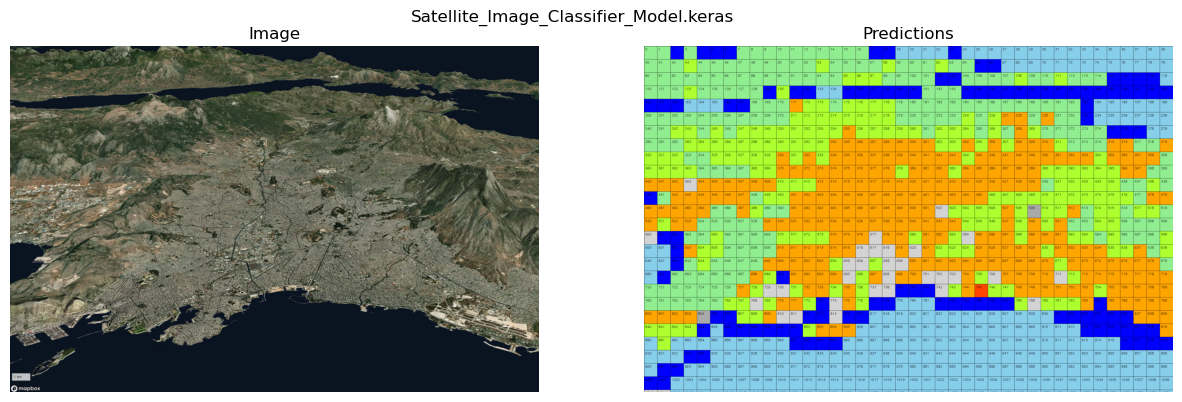

34/34 [==============================] - 6s 177ms/step


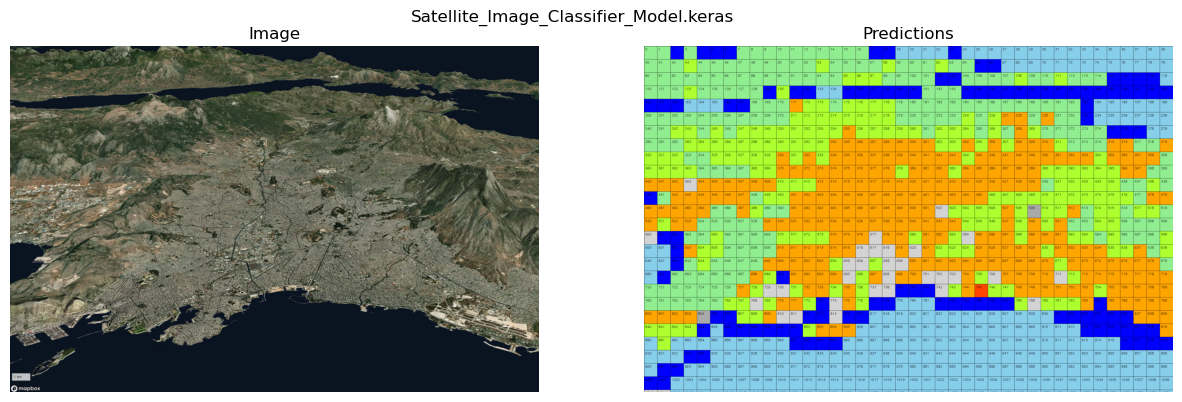

34/34 [==============================] - 7s 185ms/step


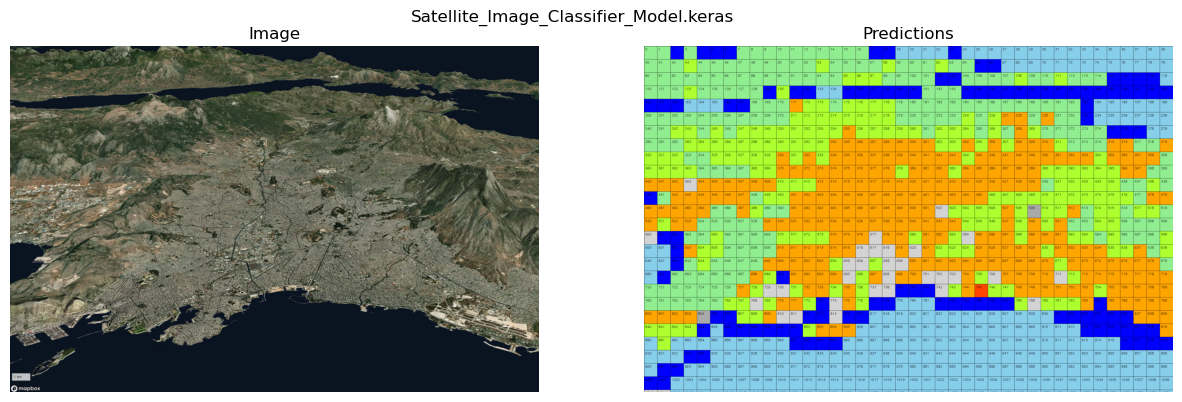

In [14]:
image = 'E:/final year project/EuroSAT/satellite image classification/Satellite Images/14.jpeg'

classifierV150I14 = SatelliteImageClassification()
classifierV150I14.load_model_SIC('C:/Users/Sowmya Gottumukkala/Satellite_Image_Classifier_Model.keras')
original_image, colored_image = classifierV150I14.process_image(image)
classifierV150I14.plot_images(original_image, colored_image)

classifierV250I14 = SatelliteImageClassification()
classifierV250I14.load_model_SIC('C:/Users/Sowmya Gottumukkala/Satellite_Image_Classifier_Model.keras')
original_image, colored_image = classifierV250I14.process_image(image)
classifierV250I14.plot_images(original_image, colored_image)

classifierV350I14 = SatelliteImageClassification()
classifierV350I14.load_model_SIC('C:/Users/Sowmya Gottumukkala/Satellite_Image_Classifier_Model.keras')
original_image, colored_image = classifierV350I14.process_image(image)
classifierV350I14.plot_images(original_image, colored_image)

6/6 [==============================] - 2s 174ms/step


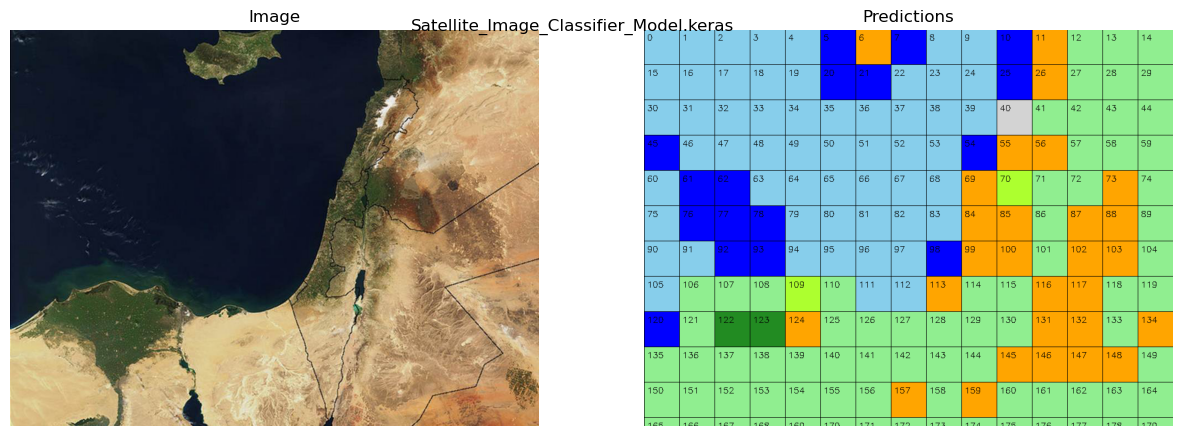

In [ ]:
image = 'E:/final year project/EuroSAT/satellite image classification/Satellite Images/1.jpeg'

classifierV150I1 = SatelliteImageClassification()
classifierV150I1.load_model_SIC('C:/Users/Sowmya Gottumukkala/Satellite_Image_Classifier_Model.keras')
original_image, colored_image = classifierV150I1.process_image(image)
classifierV150I1.plot_images(original_image, colored_image)

classifierV250I1 = SatelliteImageClassification()
classifierV250I1.load_model_SIC('C:/Users/Sowmya Gottumukkala/Satellite_Image_Classifier_Model.keras')
original_image, colored_image = classifierV250I1.process_image(image)
classifierV250I1.plot_images(original_image, colored_image)

classifierV350I1 = SatelliteImageClassification()
classifierV350I1.load_model_SIC('C:/Users/Sowmya Gottumukkala/Satellite_Image_Classifier_Model.keras')
original_image, colored_image = classifierV350I1.process_image(image)
classifierV350I1.plot_images(original_image, colored_image)

<h2 style="text-align:center">Conclusions<a class="anchor" id = "8"></a></h2>

<p>This study explored different configurations of model training to evaluate the performance of a neural network for satellite image classification. By experimenting with various configurations and adjusting the number of epochs, the optimal number of epochs that produced the best results for each version was identified. This methodical approach allowed for pinpointing the most effective models from each training version. Comparative analysis of these models revealed that Version 2 outperformed the others in class prediction accuracy. Consequently, it was determined that Version 2 was the most efficient model for classifying satellite images.</p>

<p>The quality of the dataset significantly impacted these outcomes. The images used in the dataset are 64x64 pixels, and higher resolution images could potentially enhance classification accuracy. Furthermore, implementing a more sophisticated convolutional neural network architecture could significantly improve results, leading to even better classification performance.</p>

<p>In summary, this project underscores the potential of convolutional neural networks in satellite image classification. It emphasizes the importance of careful model configuration, high-quality data, and the selection of appropriate network architectures to achieve superior classification accuracy. The findings of this study contribute valuable insights into the development and optimization of neural network models for remote sensing applications.</p>